<a href="https://colab.research.google.com/github/LeonGoergen/DocumentClassification/blob/main/classification/Transformer_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A comprehensive explanation of each model and its usage can be found at the [huggingface documentation](https://huggingface.co/docs/transformers/index)

# Dependencies

## Imports

In [ ]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.6 MB/s eta 0:00:0

In [ ]:
# For Models
import torch
from transformers import Trainer, TrainingArguments, default_data_collator, pipeline
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import XLNetTokenizerFast, XLNetForSequenceClassification
from transformers import GPT2TokenizerFast, GPT2ForSequenceClassification

# For Data Management
from sklearn.model_selection import train_test_split
import datasets
from datasets import Dataset
import numpy as np
import pandas as pd
import math
import json

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import time

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pd.set_option('display.max_rows', None)

## Data

In [ ]:
label_target = 'Product'
content_target = 'Consumer complaint narrative'

train = pd.read_csv('/content/drive/MyDrive/Bachelor Thesis/Datasets/train_nopreprocess.csv', sep="\t", header=0)
test = pd.read_csv('/content/drive/MyDrive/Bachelor Thesis/Datasets/test_nopreprocess.csv', sep="\t", header=0)

train, eval = train_test_split(train, test_size=0.15, random_state=1)

train[label_target] = pd.Categorical(train['Product']).codes
eval[label_target] = pd.Categorical(eval['Product']).codes

train_dataset = Dataset.from_pandas(train)
eval_dataset = Dataset.from_pandas(eval)

In [ ]:
id2label = {f'LABEL_{i}': pd.Categorical(train['Product']).categories[i] for i in range(train[label_target].nunique())}

## Functions

In [ ]:
def calculate_accuracy(y_actu, y_pred):
    return accuracy_score(y_actu, y_pred)

def calculate_precision(y_actu, y_pred,average='macro'):
    return precision_score(y_actu, y_pred,average=average)

def calculate_recall(y_actu, y_pred,average='macro'):
    return recall_score(y_actu, y_pred,average=average)

def calculate_f1(y_actu, y_pred,average='macro'):
    return f1_score(y_actu, y_pred,average=average)

def save_results(metrics, algorithm, method):
    name = "/content/drive/MyDrive/Bachelor Thesis/Classification/Results/" + algorithm + method + ".json"
    with open(name, "w") as outfile:
        json.dump(metrics, outfile)

def evaluate_model(y_actu, y_pred, time, training_time, algorithm, method=""):
    metrics = {}
    metrics["Algorithm"] = algorithm
    metrics["Method"] = method
    metrics["Accuracy"] = round(calculate_accuracy(y_actu, y_pred)*100, 4)
    metrics["Precision (Macro Average)"] = round(calculate_precision(y_actu, y_pred,average='macro')*100, 4)
    metrics["Precision (Micro Average)"] = round(calculate_precision(y_actu, y_pred,average='micro')*100, 4)
    metrics["Recall (Macro Average)"] = round(calculate_recall(y_actu, y_pred,average='macro')*100, 4)
    metrics["Recall (Micro Average)"] = round(calculate_recall(y_actu, y_pred,average='micro')*100, 4)
    metrics["F1-Score (Macro Average)"] = round(calculate_f1(y_actu, y_pred,average='macro')*100, 4)
    metrics["F1-Score (Micro Average)"] = round(calculate_f1(y_actu, y_pred,average='micro')*100, 4)
    metrics["time per document (ms)"] = time
    metrics["training time (min)"] = training_time

    save_results(metrics, algorithm, method)

    return metrics

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.show()

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# BERT
Bidirectional Encoder Representations from Transformers

## Setup

In [ ]:
pretrain = "bert-base-uncased"

tokenizer = BertTokenizerFast.from_pretrained(pretrain, do_lower_case=True)
model = BertForSequenceClassification.from_pretrained(pretrain, num_labels=train[label_target].nunique())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Encode Text Data

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples[content_target], padding="max_length", truncation=True)

train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
eval_tokenized_dataset = eval_dataset.map(tokenize_function, batched=True)

  0%|          | 0/69 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

## Train the Model

In [ ]:
training_args = TrainingArguments(
    output_dir='./BERT/results',
    logging_dir='./BERT/logs',
    num_train_epochs=4,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    logging_strategy="epoch",
    optim = 'adamw_torch',
    learning_rate = 3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps = 16,
    warmup_steps=500,
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=eval_tokenized_dataset,
    compute_metrics=compute_metrics,
    data_collator = default_data_collator,
)

In [ ]:
start = time.time()
trainer.train()
training_time = time.time() - start

print(training_time)

# Runtime got interrupted mid-process, which is why there are two progress bars and tables

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, Complaint ID, Tags, ZIP code, Company response to consumer, Consumer consent provided?, Company, Product, Sub-product, Sub-issue, Submitted via, Consumer complaint narrative, State, Consumer disputed?, Date received, Issue, Timely response?, Company public response, Date sent to company. If __index_level_0__, Complaint ID, Tags, ZIP code, Company response to consumer, Consumer consent provided?, Company, Product, Sub-product, Sub-issue, Submitted via, Consumer complaint narrative, State, Consumer disputed?, Date received, Issue, Timely response?, Company public response, Date sent to company are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 68102
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w.

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,2.174100,1.686208,0.521840,0.471266,0.517899,0.526456
1,1.159700,0.828004,0.719361,0.702393,0.706639,0.721106
2,0.763400,0.712589,0.766204,0.766796,0.775269,0.767038


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, Complaint ID, Tags, ZIP code, Company response to consumer, Consumer consent provided?, Company, Product, Sub-product, Sub-issue, Submitted via, Consumer complaint narrative, State, Consumer disputed?, Date received, Issue, Timely response?, Company public response, Date sent to company. If __index_level_0__, Complaint ID, Tags, ZIP code, Company response to consumer, Consumer consent provided?, Company, Product, Sub-product, Sub-issue, Submitted via, Consumer complaint narrative, State, Consumer disputed?, Date received, Issue, Timely response?, Company public response, Date sent to company are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12019
  Batch size = 16
Saving model checkpoint to ./BERT/results/checkpoint-133
Configura

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,2.174100,1.686208,0.521840,0.471266,0.517899,0.526456
1,1.159700,0.828004,0.719361,0.702393,0.706639,0.721106
2,0.763400,0.712589,0.766204,0.766796,0.775269,0.767038
3,0.627900,0.635457,0.795906,0.795144,0.796331,0.796795


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, Complaint ID, Tags, ZIP code, Company response to consumer, Consumer consent provided?, Company, Product, Sub-product, Sub-issue, Submitted via, Consumer complaint narrative, State, Consumer disputed?, Date received, Issue, Timely response?, Company public response, Date sent to company. If __index_level_0__, Complaint ID, Tags, ZIP code, Company response to consumer, Consumer consent provided?, Company, Product, Sub-product, Sub-issue, Submitted via, Consumer complaint narrative, State, Consumer disputed?, Date received, Issue, Timely response?, Company public response, Date sent to company are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12019
  Batch size = 16
Saving model checkpoint to ./BERT/results/checkpoint-532
Configura

6301.673082113266


In [ ]:
trainer.save_model("BERT/final")
!zip -r "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/BERT.zip" "/content/BERT/final"

Saving model checkpoint to BERT/final
Configuration saved in BERT/final/config.json
Model weights saved in BERT/final/pytorch_model.bin


updating: content/BERT/final/ (stored 0%)
updating: content/BERT/final/pytorch_model.bin (deflated 7%)
updating: content/BERT/final/training_args.bin (deflated 49%)
updating: content/BERT/final/config.json (deflated 57%)


### Evaluate Training

In [ ]:
train_losses = []
eval_losses = []

for d in trainer.state.log_history:
    if "loss" in d:
        train_losses.append(d["loss"])
    elif "eval_loss" in d:
        eval_losses.append(d["eval_loss"])

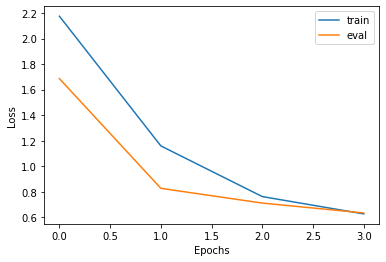

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(eval_losses, label='eval')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Inference

In [ ]:
!rm -rf "/content/BERT/final"
!mkdir -p "/content/BERT/final"
!unzip "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/BERT.zip" -d "/content/BERT/final"

pretrain = 'bert-base-uncased'
model_id = "/content/BERT/final/content/BERT/final"

Archive:  /content/drive/MyDrive/Bachelor Thesis/Classification/Models/BERT.zip
   creating: /content/BERT/final/content/BERT/
  inflating: /content/BERT/final/content/BERT/pytorch_model.bin  
  inflating: /content/BERT/final/content/BERT/training_args.bin  
  inflating: /content/BERT/final/content/BERT/config.json  
   creating: /content/BERT/final/content/BERT/final/
  inflating: /content/BERT/final/content/BERT/final/pytorch_model.bin  
  inflating: /content/BERT/final/content/BERT/final/training_args.bin  
  inflating: /content/BERT/final/content/BERT/final/config.json  


In [ ]:
pipe = pipeline("text-classification", model=model_id, tokenizer=BertTokenizerFast.from_pretrained(pretrain))
tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':512}

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = id2label[pipe(sample, **tokenizer_kwargs)[0]['label']]
    y_pred.append(prediction)
    y_actu.append(row['Product'])
    predictions.append([prediction, row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluate Results

In [ ]:
print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "BERT", "Base")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,BERT
1,Method,Base
2,Accuracy,79.5672
3,Precision (Macro Average),79.5217
4,Precision (Micro Average),79.5672
5,Recall (Macro Average),79.5194
6,Recall (Micro Average),79.5672
7,F1-Score (Macro Average),79.4094
8,F1-Score (Micro Average),79.5672
9,time per document (ms),20.49


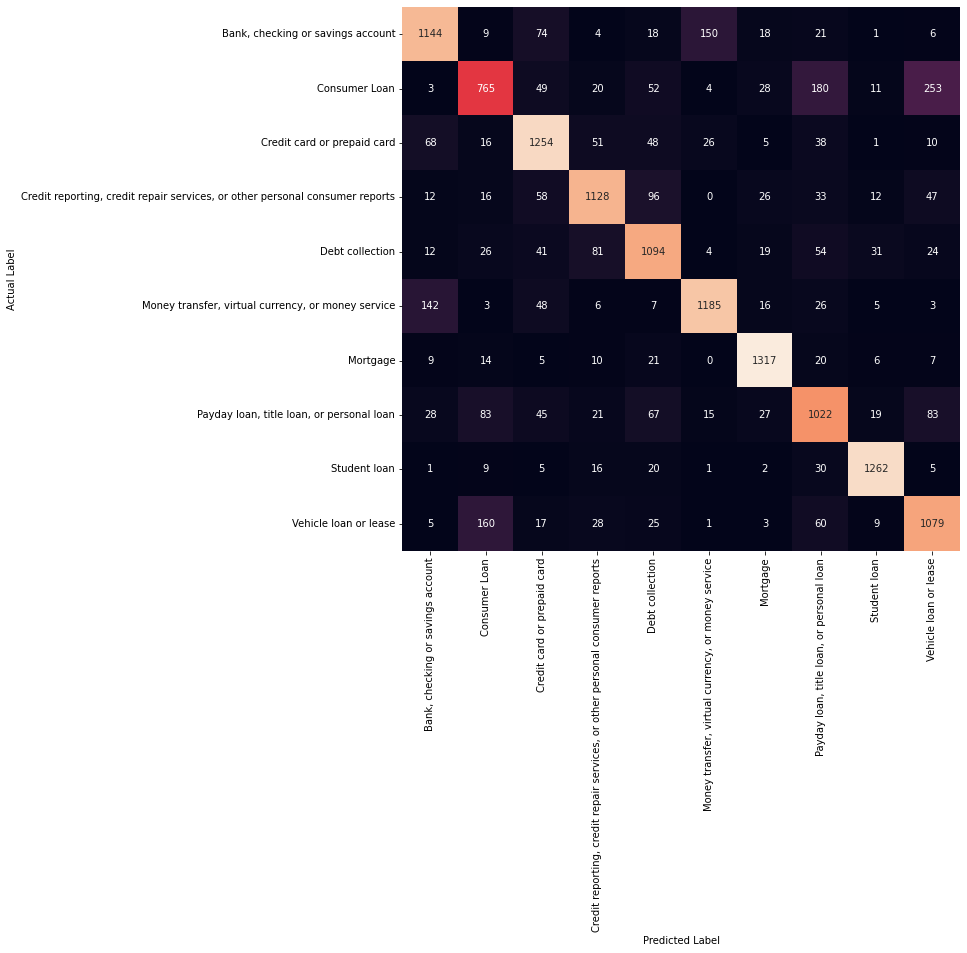

In [ ]:
plot_confusion_matrix(y_actu, y_pred, sorted(test["Product"].unique()))

# RoBERTa
Robustly Optimized BERT Pre-training Approach

## Setup

In [ ]:
pretrain = "roberta-base"

tokenizer = RobertaTokenizerFast.from_pretrained(pretrain, do_lower_case=True)
model = RobertaForSequenceClassification.from_pretrained(pretrain, num_labels=train[label_target].nunique())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

### Encode Text Data

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples[content_target], padding="max_length", truncation=True)

train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
eval_tokenized_dataset = eval_dataset.map(tokenize_function, batched=True)

  0%|          | 0/69 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

## Train the Model

* output_dir: This argument defines the path to the directory where the training results, such as the trained model, will be saved.

* logging_dir: This argument defines the path to the directory where the training logs will be saved. These logs can include information such as the training and evaluation loss, accuracy, and other metrics.

* num_train_epochs: This argument sets the number of times the model will iterate over the entire training dataset. The more epochs, the more the model will learn and improve. However, too many epochs may result in overfitting.

* evaluation_strategy: This argument sets the strategy for evaluating the model's performance. In this case, the strategy is set to "epoch", which means that the model will be evaluated after each training epoch.

* save_strategy: This argument sets the strategy for saving the model's weights. In this case, the strategy is set to "epoch", which means that the model will be saved after each training epoch.

* logging_strategy: This argument sets the strategy for logging the training progress. In this case, the strategy is set to "epoch", which means that the training progress will be logged after each epoch.

* optim: This argument sets the optimization algorithm used for training. In this case, the optimization algorithm is set to "adamw_torch", which is the AdamW algorithm implemented in PyTorch. The AdamW algorithm is a variant of the Adam optimization algorithm that includes weight decay.

* learning_rate: This argument sets the learning rate, which is the step size used in the optimization algorithm to update the model parameters. A high learning rate results in quick updates to the parameters, while a low learning rate results in slower updates. The learning rate is set to 3e-5, which is a common value for BERT models.

* per_device_train_batch_size: This argument sets the batch size for training on each device. The batch size determines the number of samples used in one forward/backward pass. A larger batch size can lead to faster training but may also consume more memory.

* per_device_eval_batch_size: This argument sets the batch size for evaluation on each device. The evaluation batch size should be smaller than the training batch size to avoid memory issues during evaluation.

* gradient_accumulation_steps: This argument sets the number of steps for gradient accumulation. Gradient accumulation is used to update the model's parameters more frequently than after each batch. This can be useful when the batch size is small or when training on multiple GPUs.

* warmup_steps: This argument sets the number of warm-up steps before starting the training. The warm-up steps are used to adjust the learning rate gradually and avoid large fluctuations in the loss.


* load_best_model_at_end: This argument sets whether to load the best model at the end of training. In this case, it is set to True, which means that the model with the best performance on the evaluation dataset will be loaded.

In [ ]:
training_args = TrainingArguments(
    output_dir='./RoBERTa/results',
    logging_dir='./RoBERTa/logs',
    num_train_epochs=4,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    logging_strategy="epoch",
    optim = 'adamw_torch',
    learning_rate = 3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps = 16,
    warmup_steps=500,
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=eval_tokenized_dataset,
    compute_metrics=compute_metrics,
    data_collator = default_data_collator,
)

In [ ]:
start = time.time()
trainer.train()
training_time = time.time() - start

print(training_time)

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Company response to consumer, Consumer complaint narrative, Timely response?, Date sent to company, State, __index_level_0__, Company public response, Product, Sub-product, Consumer consent provided?, Tags, Company, Sub-issue, Submitted via, Complaint ID, Date received, Issue, ZIP code, Consumer disputed?. If Company response to consumer, Consumer complaint narrative, Timely response?, Date sent to company, State, __index_level_0__, Company public response, Product, Sub-product, Consumer consent provided?, Tags, Company, Sub-issue, Submitted via, Complaint ID, Date received, Issue, ZIP code, Consumer disputed? are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 68102
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch si

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,1.515600,0.808579,0.722523,0.714268,0.712009,0.724167


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Company response to consumer, Consumer complaint narrative, Timely response?, Date sent to company, State, __index_level_0__, Company public response, Product, Sub-product, Consumer consent provided?, Tags, Company, Sub-issue, Submitted via, Complaint ID, Date received, Issue, ZIP code, Consumer disputed?. If Company response to consumer, Consumer complaint narrative, Timely response?, Date sent to company, State, __index_level_0__, Company public response, Product, Sub-product, Consumer consent provided?, Tags, Company, Sub-issue, Submitted via, Complaint ID, Date received, Issue, ZIP code, Consumer disputed? are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12019
  Batch size = 8
Saving model checkpoint to ./RoBERTa/results/checkpoint-266
C

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,1.515600,0.808579,0.722523,0.714268,0.712009,0.724167
1,0.751100,0.683875,0.774607,0.771566,0.777975,0.775473
2,0.590900,0.609474,0.800566,0.800672,0.800802,0.801326
3,0.484900,0.601731,0.805475,0.805761,0.805706,0.806301


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: Company response to consumer, Consumer complaint narrative, Timely response?, Date sent to company, State, __index_level_0__, Company public response, Product, Sub-product, Consumer consent provided?, Tags, Company, Sub-issue, Submitted via, Complaint ID, Date received, Issue, ZIP code, Consumer disputed?. If Company response to consumer, Consumer complaint narrative, Timely response?, Date sent to company, State, __index_level_0__, Company public response, Product, Sub-product, Consumer consent provided?, Tags, Company, Sub-issue, Submitted via, Complaint ID, Date received, Issue, ZIP code, Consumer disputed? are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12019
  Batch size = 8
Saving model checkpoint to ./RoBERTa/results/checkpoint-532
C

25320.177682876587


In [ ]:
trainer.save_model("RoBERTa/final")
!zip -r "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/RoBERTa.zip" "/content/RoBERTa/final"

Saving model checkpoint to RoBERTa/final
Configuration saved in RoBERTa/final/config.json
Model weights saved in RoBERTa/final/pytorch_model.bin


  adding: content/RoBERTa/final/ (stored 0%)
  adding: content/RoBERTa/final/pytorch_model.bin (deflated 10%)
  adding: content/RoBERTa/final/config.json (deflated 58%)
  adding: content/RoBERTa/final/training_args.bin (deflated 49%)


### Evaluate Training

In [ ]:
train_losses = []
eval_losses = []

for d in trainer.state.log_history:
    if "loss" in d:
        train_losses.append(d["loss"])
    elif "eval_loss" in d:
        eval_losses.append(d["eval_loss"])

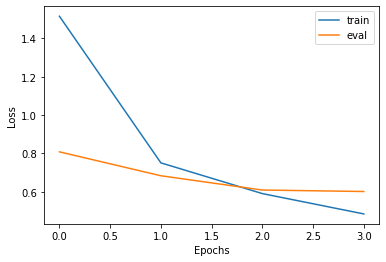

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(eval_losses, label='eval')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Inference

In [ ]:
!rm -rf "/content/RoBERTa/final"
!mkdir -p "/content/RoBERTa/final"
!unzip "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/RoBERTa.zip" -d "/content/RoBERTa/final"

pretrain = 'roberta-base'
model_id = "/content/RoBERTa/final/content/RoBERTa/final"

Archive:  /content/drive/MyDrive/Bachelor Thesis/Classification/Models/RoBERTa.zip
   creating: /content/RoBERTa/final/content/RoBERTa/final/
  inflating: /content/RoBERTa/final/content/RoBERTa/final/pytorch_model.bin  
  inflating: /content/RoBERTa/final/content/RoBERTa/final/config.json  
  inflating: /content/RoBERTa/final/content/RoBERTa/final/training_args.bin  


In [ ]:
pipe = pipeline("text-classification", model=model_id, tokenizer=RobertaTokenizerFast.from_pretrained(pretrain), device=0)
tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':512}

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = id2label[pipe(sample, **tokenizer_kwargs)[0]['label']]
    y_pred.append(prediction)
    y_actu.append(row['Product'])
    predictions.append([prediction, row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

  0%|          | 8/14139 [00:03<1:02:45,  3.75it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 14139/14139 [05:13<00:00, 45.16it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluate Results

In [ ]:
print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "RoBERTa", "Base")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,RoBERTa
1,Method,Base
2,Accuracy,81.2929
3,Precision (Macro Average),81.2471
4,Precision (Micro Average),81.2929
5,Recall (Macro Average),81.289
6,Recall (Micro Average),81.2929
7,F1-Score (Macro Average),81.2503
8,F1-Score (Micro Average),81.2929
9,time per document (ms),22.15


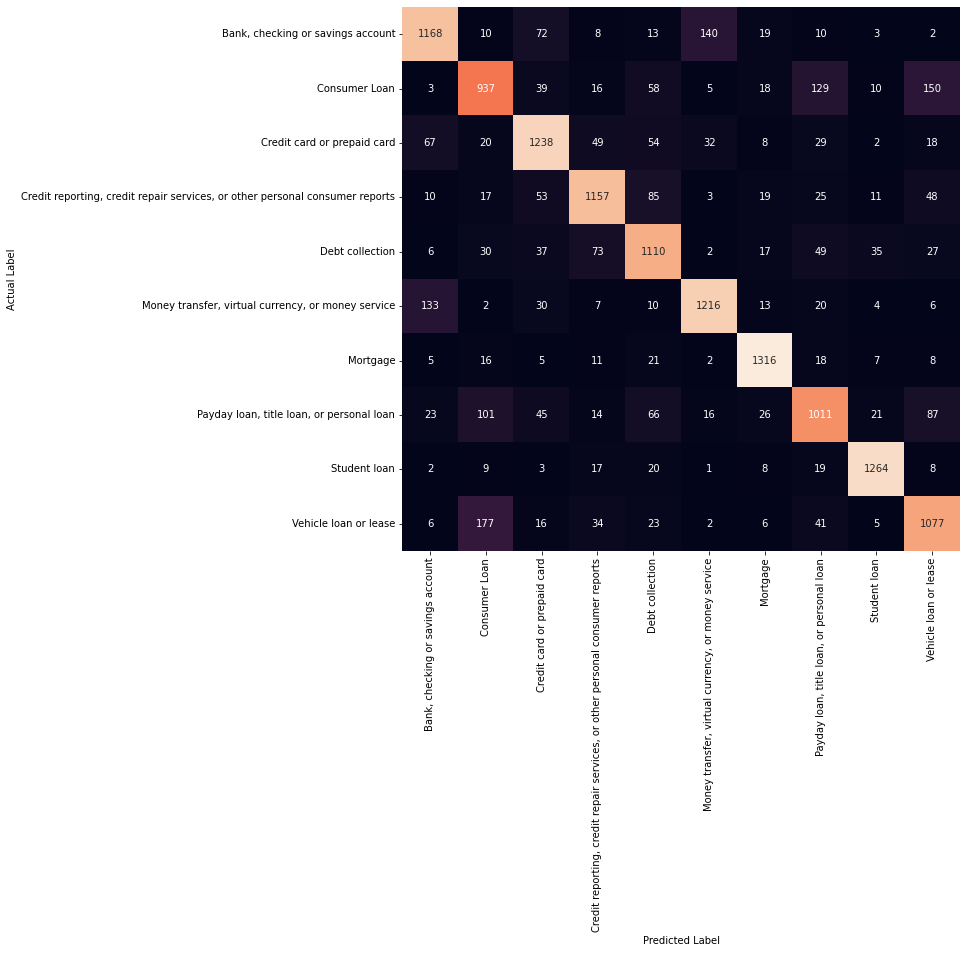

In [ ]:
plot_confusion_matrix(y_actu, y_pred, sorted(test["Product"].unique()))

# XLNet
Generalized Auto-Regressive model

## Setup

In [ ]:
pretrain = 'xlnet-base-cased'

tokenizer = XLNetTokenizerFast.from_pretrained(pretrain, do_lower_case=True)
model = XLNetForSequenceClassification.from_pretrained(pretrain, num_labels=train[label_target].nunique())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/spiece.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.26.0",
  "untie_r":

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/ceaa69c7bc5e512b5007106a7ccbb7daf24b2c79/pytorch_model.bin
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.weigh

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward

### Encode Text Data

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples[content_target], padding='max_length', truncation=True, max_length=512)

train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
eval_tokenized_dataset = eval_dataset.map(tokenize_function, batched=True)

  0%|          | 0/69 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

## Train the Model

* output_dir: This argument defines the path to the directory where the training results, such as the trained model, will be saved.

* logging_dir: This argument defines the path to the directory where the training logs will be saved. These logs can include information such as the training and evaluation loss, accuracy, and other metrics.

* num_train_epochs: This argument sets the number of times the model will iterate over the entire training dataset. The more epochs, the more the model will learn and improve. However, too many epochs may result in overfitting.

* evaluation_strategy: This argument sets the strategy for evaluating the model's performance. In this case, the strategy is set to "epoch", which means that the model will be evaluated after each training epoch.

* save_strategy: This argument sets the strategy for saving the model's weights. In this case, the strategy is set to "epoch", which means that the model will be saved after each training epoch.

* logging_strategy: This argument sets the strategy for logging the training progress. In this case, the strategy is set to "epoch", which means that the training progress will be logged after each epoch.

* optim: This argument sets the optimization algorithm used for training. In this case, the optimization algorithm is set to "adamw_torch", which is the AdamW algorithm implemented in PyTorch. The AdamW algorithm is a variant of the Adam optimization algorithm that includes weight decay.

* learning_rate: This argument sets the learning rate, which is the step size used in the optimization algorithm to update the model parameters. A high learning rate results in quick updates to the parameters, while a low learning rate results in slower updates. The learning rate is set to 3e-5, which is a common value for BERT models.

* per_device_train_batch_size: This argument sets the batch size for training on each device. The batch size determines the number of samples used in one forward/backward pass. A larger batch size can lead to faster training but may also consume more memory.

* per_device_eval_batch_size: This argument sets the batch size for evaluation on each device. The evaluation batch size should be smaller than the training batch size to avoid memory issues during evaluation.

* gradient_accumulation_steps: This argument sets the number of steps for gradient accumulation. Gradient accumulation is used to update the model's parameters more frequently than after each batch. This can be useful when the batch size is small or when training on multiple GPUs.

* warmup_steps: This argument sets the number of warm-up steps before starting the training. The warm-up steps are used to adjust the learning rate gradually and avoid large fluctuations in the loss.


* load_best_model_at_end: This argument sets whether to load the best model at the end of training. In this case, it is set to True, which means that the model with the best performance on the evaluation dataset will be loaded.

In [ ]:
training_args = TrainingArguments(
    output_dir='./XLNet/results',
    logging_dir='./XLNet/logs',
    num_train_epochs=4,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    logging_strategy="epoch",
    optim = 'adamw_torch',
    learning_rate = 3e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps = 16,
    warmup_steps=500,
    load_best_model_at_end=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=eval_tokenized_dataset,
    compute_metrics=compute_metrics,
    data_collator = default_data_collator,
)

In [ ]:
start = time.time()
trainer.train()
training_time = time.time() - start

print(training_time)

The following columns in the training set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: __index_level_0__, Complaint ID, Tags, ZIP code, Company response to consumer, Consumer consent provided?, Company, Product, Sub-product, Sub-issue, Submitted via, Consumer complaint narrative, State, Consumer disputed?, Date received, Issue, Timely response?, Company public response, Date sent to company. If __index_level_0__, Complaint ID, Tags, ZIP code, Company response to consumer, Consumer consent provided?, Company, Product, Sub-product, Sub-issue, Submitted via, Consumer complaint narrative, State, Consumer disputed?, Date received, Issue, Timely response?, Company public response, Date sent to company are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 68102
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,1.857600,0.979308,0.663283,0.656997,0.652858,0.664664
1,0.878500,0.758680,0.738997,0.734044,0.734562,0.740140
2,0.723900,0.677266,0.777769,0.776986,0.776667,0.778476
3,0.609600,0.619451,0.798985,0.799731,0.800784,0.799563


The following columns in the evaluation set don't have a corresponding argument in `XLNetForSequenceClassification.forward` and have been ignored: __index_level_0__, Complaint ID, Tags, ZIP code, Company response to consumer, Consumer consent provided?, Company, Product, Sub-product, Sub-issue, Submitted via, Consumer complaint narrative, State, Consumer disputed?, Date received, Issue, Timely response?, Company public response, Date sent to company. If __index_level_0__, Complaint ID, Tags, ZIP code, Company response to consumer, Consumer consent provided?, Company, Product, Sub-product, Sub-issue, Submitted via, Consumer complaint narrative, State, Consumer disputed?, Date received, Issue, Timely response?, Company public response, Date sent to company are not expected by `XLNetForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12019
  Batch size = 16
Saving model checkpoint to ./XLNet/results/checkpoint-133
Config

13537.615504026413


In [ ]:
trainer.save_model("XLNet/final")
!zip -r "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/XLNet.zip" "/content/XLNet/final"

Saving model checkpoint to XLNet/final
Configuration saved in XLNet/final/config.json
Model weights saved in XLNet/final/pytorch_model.bin


  adding: content/XLNet/final/ (stored 0%)
  adding: content/XLNet/final/pytorch_model.bin (deflated 7%)
  adding: content/XLNet/final/training_args.bin (deflated 49%)
  adding: content/XLNet/final/config.json (deflated 58%)


### Evaluate Training

In [ ]:
train_losses = []
eval_losses = []

for d in trainer.state.log_history:
    if "loss" in d:
        train_losses.append(d["loss"])
    elif "eval_loss" in d:
        eval_losses.append(d["eval_loss"])

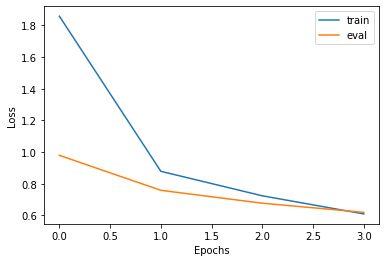

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(eval_losses, label='eval')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Inference

In [ ]:
!rm -rf "/content/XLNet/final"
!mkdir -p "/content/XLNet/final"
!unzip "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/XLNet.zip" -d "/content/XLNet/final"

pretrain = 'xlnet-base-cased'
model_id = "/content/XLNet/final/content/XLNet/final"

Archive:  /content/drive/MyDrive/Bachelor Thesis/Classification/Models/XLNet.zip
   creating: /content/XLNet/final/content/XLNet/final/
  inflating: /content/XLNet/final/content/XLNet/final/pytorch_model.bin  
  inflating: /content/XLNet/final/content/XLNet/final/training_args.bin  
  inflating: /content/XLNet/final/content/XLNet/final/config.json  


In [ ]:
pipe = pipeline("text-classification", model=model_id, tokenizer=XLNetTokenizerFast.from_pretrained(pretrain), device=0)
tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':512}

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = id2label[pipe(sample, **tokenizer_kwargs)[0]['label']]
    y_pred.append(prediction)
    y_actu.append(row['Product'])
    predictions.append([prediction, row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

  0%|          | 10/14139 [00:00<13:15, 17.77it/s]/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 14139/14139 [08:42<00:00, 27.07it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluate Results

In [ ]:
print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "XLNet", "Base")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,XLNet
1,Method,Base
2,Accuracy,80.2037
3,Precision (Macro Average),80.2627
4,Precision (Micro Average),80.2037
5,Recall (Macro Average),80.1896
6,Recall (Micro Average),80.2037
7,F1-Score (Macro Average),80.198
8,F1-Score (Micro Average),80.2037
9,time per document (ms),36.95


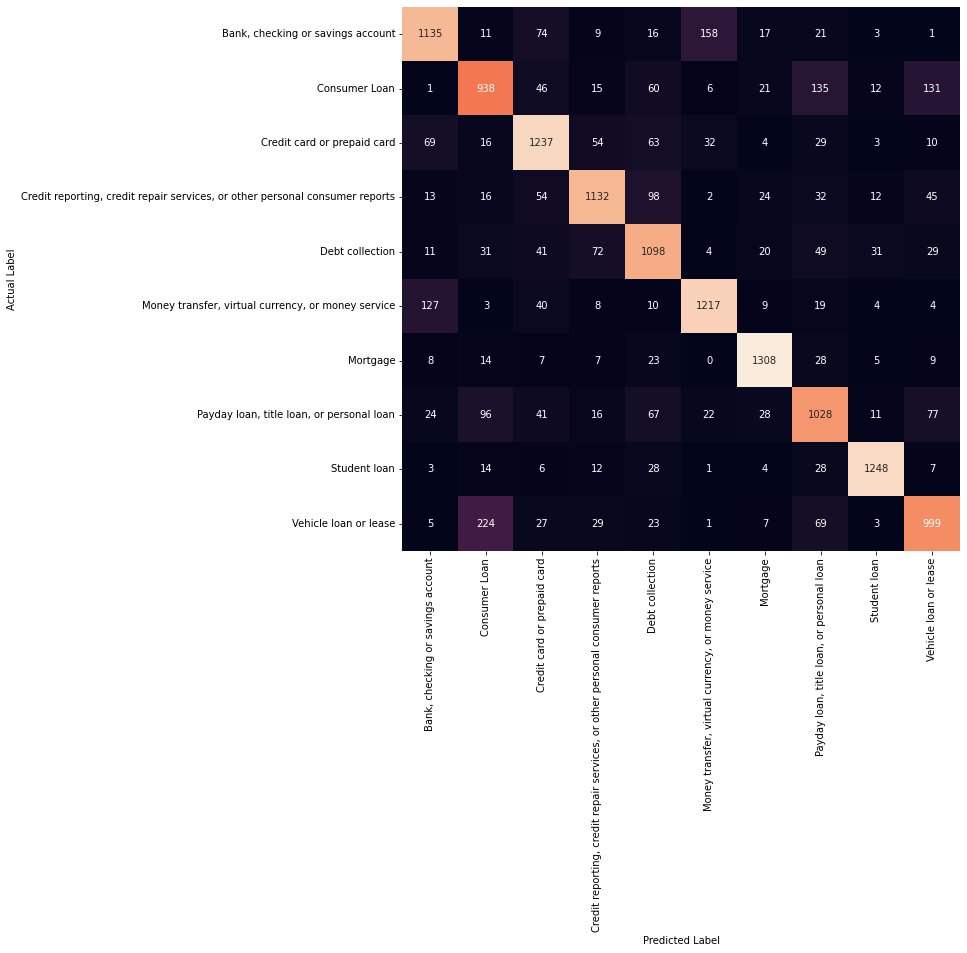

In [ ]:
plot_confusion_matrix(y_actu, y_pred, sorted(test["Product"].unique()))

# GPT-2
Generative Pre-trained Transformer

## Setup

In [ ]:
pretrain = 'gpt2'

tokenizer = GPT2TokenizerFast.from_pretrained(pretrain, do_lower_case=True)
model = GPT2ForSequenceClassification.from_pretrained(pretrain, num_labels=train[label_target].nunique())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid

### Encode Text Data

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples[content_target], padding="max_length", truncation=True)

train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
eval_tokenized_dataset = eval_dataset.map(tokenize_function, batched=True)

  0%|          | 0/69 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

## Train the Model

* output_dir: This argument defines the path to the directory where the training results, such as the trained model, will be saved.

* logging_dir: This argument defines the path to the directory where the training logs will be saved. These logs can include information such as the training and evaluation loss, accuracy, and other metrics.

* num_train_epochs: This argument sets the number of times the model will iterate over the entire training dataset. The more epochs, the more the model will learn and improve. However, too many epochs may result in overfitting.

* evaluation_strategy: This argument sets the strategy for evaluating the model's performance. In this case, the strategy is set to "epoch", which means that the model will be evaluated after each training epoch.

* save_strategy: This argument sets the strategy for saving the model's weights. In this case, the strategy is set to "epoch", which means that the model will be saved after each training epoch.

* logging_strategy: This argument sets the strategy for logging the training progress. In this case, the strategy is set to "epoch", which means that the training progress will be logged after each epoch.

* optim: This argument sets the optimization algorithm used for training. In this case, the optimization algorithm is set to "adamw_torch", which is the AdamW algorithm implemented in PyTorch. The AdamW algorithm is a variant of the Adam optimization algorithm that includes weight decay.

* learning_rate: This argument sets the learning rate, which is the step size used in the optimization algorithm to update the model parameters. A high learning rate results in quick updates to the parameters, while a low learning rate results in slower updates. The learning rate is set to 3e-5, which is a common value for BERT models.

* per_device_train_batch_size: This argument sets the batch size for training on each device. The batch size determines the number of samples used in one forward/backward pass. A larger batch size can lead to faster training but may also consume more memory.

* per_device_eval_batch_size: This argument sets the batch size for evaluation on each device. The evaluation batch size should be smaller than the training batch size to avoid memory issues during evaluation.

* gradient_accumulation_steps: This argument sets the number of steps for gradient accumulation. Gradient accumulation is used to update the model's parameters more frequently than after each batch. This can be useful when the batch size is small or when training on multiple GPUs.

* warmup_steps: This argument sets the number of warm-up steps before starting the training. The warm-up steps are used to adjust the learning rate gradually and avoid large fluctuations in the loss.


* load_best_model_at_end: This argument sets whether to load the best model at the end of training. In this case, it is set to True, which means that the model with the best performance on the evaluation dataset will be loaded.

In [ ]:
training_args = TrainingArguments(
    output_dir='./GPT2/results',
    logging_dir='./GPT2/logs',
    num_train_epochs=4,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    logging_strategy="epoch",
    optim = 'adamw_torch',
    learning_rate = 3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps = 16,
    warmup_steps=500,
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=eval_tokenized_dataset,
    compute_metrics=compute_metrics,
    data_collator = default_data_collator,
)

In [ ]:
start = time.time()
trainer.train()
training_time = time.time() - start

print(training_time)

The following columns in the training set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: Issue, ZIP code, Timely response?, Consumer consent provided?, Complaint ID, Submitted via, Tags, Sub-product, State, Consumer complaint narrative, Date received, Product, Sub-issue, __index_level_0__, Company public response, Date sent to company, Consumer disputed?, Company, Company response to consumer. If Issue, ZIP code, Timely response?, Consumer consent provided?, Complaint ID, Submitted via, Tags, Sub-product, State, Consumer complaint narrative, Date received, Product, Sub-issue, __index_level_0__, Company public response, Date sent to company, Consumer disputed?, Company, Company response to consumer are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 68102
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,1.984300,0.854595,0.718030,0.715213,0.716872,0.719130
1,0.777200,0.708275,0.764623,0.762788,0.763336,0.765644
2,0.647500,0.668255,0.779266,0.780292,0.782218,0.780098
3,0.590300,0.658363,0.787586,0.787332,0.787433,0.788483


The following columns in the evaluation set don't have a corresponding argument in `GPT2ForSequenceClassification.forward` and have been ignored: Issue, ZIP code, Timely response?, Consumer consent provided?, Complaint ID, Submitted via, Tags, Sub-product, State, Consumer complaint narrative, Date received, Product, Sub-issue, __index_level_0__, Company public response, Date sent to company, Consumer disputed?, Company, Company response to consumer. If Issue, ZIP code, Timely response?, Consumer consent provided?, Complaint ID, Submitted via, Tags, Sub-product, State, Consumer complaint narrative, Date received, Product, Sub-issue, __index_level_0__, Company public response, Date sent to company, Consumer disputed?, Company, Company response to consumer are not expected by `GPT2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 12019
  Batch size = 4
Saving model checkpoint to ./GPT2/results/checkpoint-532
Configurat

17431.21736049652


In [ ]:
trainer.save_model("GPT2/final")
!zip -r "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/GPT2.zip" "/content/GPT2/final"

Saving model checkpoint to GPT2/final
Configuration saved in GPT2/final/config.json
Model weights saved in GPT2/final/pytorch_model.bin


  adding: content/GPT2/final/ (stored 0%)
  adding: content/GPT2/final/training_args.bin (deflated 49%)
  adding: content/GPT2/final/pytorch_model.bin (deflated 9%)
  adding: content/GPT2/final/config.json (deflated 58%)


### Evaluate Training

In [ ]:
train_losses = []
eval_losses = []

for d in trainer.state.log_history:
    if "loss" in d:
        train_losses.append(d["loss"])
    elif "eval_loss" in d:
        eval_losses.append(d["eval_loss"])

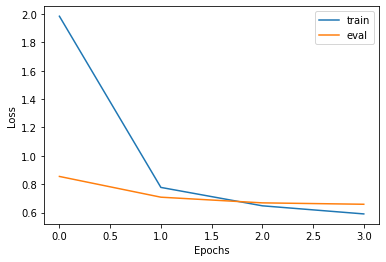

In [ ]:
plt.plot(train_losses, label='train')
plt.plot(eval_losses, label='eval')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

## Inference

In [ ]:
!rm -rf "/content/GPT2/final"
!mkdir -p "/content/GPT2/final"
!unzip "/content/drive/MyDrive/Bachelor Thesis/Classification/Models/GPT2.zip" -d "/content/GPT2/final"

pretrain = 'gpt2'
model_id = "/content/GPT2/final/content/GPT2/final"

Archive:  /content/drive/MyDrive/Bachelor Thesis/Classification/Models/GPT2.zip
   creating: /content/GPT2/final/content/GPT2/final/
  inflating: /content/GPT2/final/content/GPT2/final/training_args.bin  
  inflating: /content/GPT2/final/content/GPT2/final/pytorch_model.bin  
  inflating: /content/GPT2/final/content/GPT2/final/config.json  


In [ ]:
model = GPT2ForSequenceClassification.from_pretrained(model_id)
tokenizer = GPT2TokenizerFast.from_pretrained(pretrain)

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)
tokenizer_kwargs = {'padding':True, 'truncation':True, 'max_length':512}

In [ ]:
predictions, y_actu, y_pred = [], [], []

start_time = time.time()
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    sample = str(row['Consumer complaint narrative'])
    prediction = id2label[pipe(sample, **tokenizer_kwargs)[0]['label']]
    y_pred.append(prediction)
    y_actu.append(row['Product'])
    predictions.append([prediction, row['Product'], sample, row['Complaint ID']])
full_time = time.time() - start_time

  0%|          | 9/14139 [00:02<38:31,  6.11it/s]  /usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 14139/14139 [07:01<00:00, 33.52it/s]


In [ ]:
results = pd.DataFrame(predictions, columns=['Prediction', 'Actual Answer', 'Textual Content', 'Complaint ID'])
# results

### Evaluate Results

In [ ]:
print("tested on " + str(test.shape[0]) + " documents")

evaluation = evaluate_model(y_actu, y_pred, round(full_time/test.shape[0]*1000, 2), round(training_time/60, 2), "GPT-2")

eval_df = pd.DataFrame(evaluation.items())
eval_df

,0,1
0,Algorithm,GPT-2
1,Method,
2,Accuracy,78.2587
3,Precision (Macro Average),78.2006
4,Precision (Micro Average),78.2587
5,Recall (Macro Average),78.2425
6,Recall (Micro Average),78.2587
7,F1-Score (Macro Average),78.1525
8,F1-Score (Micro Average),78.2587
9,time per document (ms),29.83


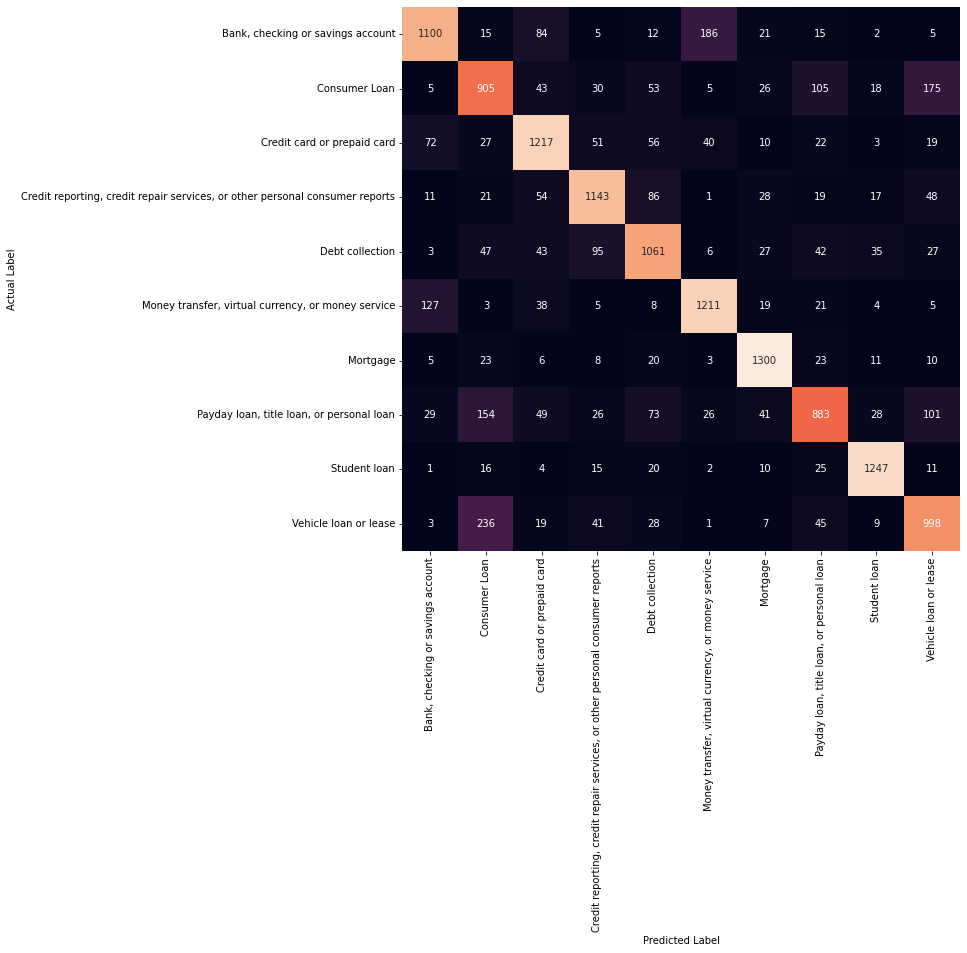

In [ ]:
plot_confusion_matrix(y_actu, y_pred, sorted(test["Product"].unique()))